**Explain what the dataset is and where to find the explanation for what the columns mean. Better yet, add the explanations for the columns into markdown.**


https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html

Our question is as follows: given a classifier method that maps the properties of the potential planet and its star (call these the “X” variables) to whether or not it is confirmed as an exoplanet (call this “Y”), can we estimate the accuracy of this method in the set of unclassified planets, where the distribution of the X variables is sometimes very different from the distribution of these variables in the classified planets? 

Even if we assume that Y depends on the X variables in the same way across the observations that are officially classified (training set) and the observations that are not yet classified (test set), we may still have inference issues if the distribution of the X variables differs across these sets. For example, if the objects in our training set tend to be larger than the objects in the test set, and larger objects are more likely to be confirmed as exoplanets, the joint distribution of X and Y will be different in the test and training set. As a result, we need to adjust for this when making inferences about our predictions for Y in the test set by using the classifier fitted on the training set. Our goal is to find a method for creating confidence sets that contain the true value of Y in the testing data with a certain frequency (i.e. 1 − α) even though the distribution of X in this data can be very different from the distribution of X in the training data.

Our primary methodology is using logistic regression as our classification method and weighted full conformal prediction for inference.

The beauty of conformal prediction is the (mostly) assumption free predictions it offers. Many ML models require some assumptions about how the data is distributed and offer no guarantees on how well it will fit the data. However, conformal prediction **gurantees** confidence intervals to contain the predicted value $\alpha$ amount of the time. The only assumption it makes to achieve this guaranteed coverage is that the *training set and test sets are exchangeable*. This is a sightly weaker assumption than the standard IID imposed in standard machine learning. 

This is the motivation for the project: Given some training and unknown test data, can we adjust the test data through weighting so that the training and test sets are exchangeable. That is, their joint distributions are equivalent. So if we were to shuffle the test set and training sets, their respective distributions would stay the same.

In the KOI dataset, this is not the case. Therefore, we will need to readjust the test set through a combination of PCA and KNN so that it does approximately conform to the exchangeability assumption; thereby giving us the guranteed prediction intervals from conformal prediction. 

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from math import log2
from tqdm import tqdm
from scipy.stats import kstest, permutation_test
# from sklearn.preprocessing import StandardScaler, PCA
plt.rcParams["figure.figsize"] = (9,9)
sns.set_style('dark')
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None


In [3]:
df = pd.read_csv('KOI.csv')
df.head()

,kepid,koi_disposition,ra,dec,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2
0,10797460,CONFIRMED,291.93423,48.141651,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,170.538750,0.002160,-0.002160,0.146,0.318,-0.146,2.95750,0.08190,-0.08190,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,NaN,NaN,93.59,29.45,-16.65,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061
1,10797460,CONFIRMED,291.93423,48.141651,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,-0.003520,0.586,0.059,-0.443,4.50700,0.11600,-0.11600,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,NaN,NaN,9.11,2.87,-1.62,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061
2,10811496,FALSE POSITIVE,297.00482,48.134129,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.78220,0.03410,-0.03410,10829.0,171.0,-171.0,14.60,3.92,-1.31,638.0,NaN,NaN,39.30,31.04,-10.49,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078
3,10848459,FALSE POSITIVE,285.53461,48.285210,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.50,-2.83,1395.0,NaN,NaN,891.96,668.95,-230.35,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067
4,10854555,CONFIRMED,288.75488,48.226200,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,171.595550,0.001130,-0.001130,0.701,0.235,-0.478,1.65450,0.04200,-0.04200,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,NaN,NaN,926.16,874.33,-314.24,6031.0,169.0,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133


In [4]:
predictor_list = df.columns[~df.columns.str.contains('err')].values
error_list = df.columns[df.columns.str.contains('err')].values

In [5]:
df.columns

Index(['kepid', 'koi_disposition', 'ra', 'dec', 'koi_fpflag_nt',
       'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period',
       'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
       'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
       'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth',
       'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1',
       'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol',
       'koi_insol_err1', 'koi_insol_err2', 'koi_steff', 'koi_steff_err1',
       'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2'],
      dtype='object')

#### Error Confidence Permutation Test

In [6]:
# This is formatting for doing permutation test.
error_df = df[error_list]
error_df['koi_disposition'] = df['koi_disposition']

# WHY DO WE DROP TEQ?

error_df.drop(['koi_teq_err1','koi_teq_err2' ],axis=1, inplace=True)
error_df.dropna(inplace=True)

new_names = 'koi_period koi_time0bk koi_impact koi_duration koi_depth koi_prad koi_insol koi_steff koi_slogg koi_srad'.split(' ')
new_cols = {}
for col in new_names:
    idx1, idx2 = np.where(error_df.columns.str.contains(col))[0]
    new_cols[col+'_error'] = error_df.iloc[:,idx1] - error_df.iloc[:,idx2]
error_df = pd.concat([error_df, pd.DataFrame(new_cols)],axis=1)

# The candidate label means it is unknown, this will be our test set. 
error_df_train = error_df[error_df.koi_disposition != 'CANDIDATE']
error_df_test = error_df[error_df.koi_disposition == 'CANDIDATE']
error_df_train['koi_disposition'] = np.where(error_df_train['koi_disposition'] == 'CONFIRMED', 1, 0)

In [7]:
error_columns = error_df.loc[:,error_df_train.columns.str.endswith('error')]

In [8]:
# Checks p value for the error columns interval. 
p_vals = {}
for col_number in range(21,31):
    results = permutation_test([error_df_train.iloc[:, col_number], error_df_train['koi_disposition']], statistic=scipy.stats.pearsonr, permutation_type='pairings', n_resamples=5000)
    pvalue = results.pvalue[0]
    p_vals[error_df.columns[col_number]] = pvalue
table = pd.DataFrame(pd.Series(p_vals), columns=['p-value'])
table.index.names = ['Error Variable Name']

ValueError: operands could not be broadcast together with shapes (2,5000) (2,) 

In [95]:
# table

In [98]:
error_train = error_df_train.loc[:,error_df_train.columns.str.endswith('error')]
error_test = error_df_test.loc[:,error_df_test.columns.str.endswith('error')]

The first step to obtain valid inference was to figure out which predictors had different distributions across the training and test data. We wanted to quantify this difference using the Kolmogorov-Smirnov (K-S) statistic for each predictor

In [138]:
# # # Checks the KS p value for the error columns interval. 
# p_vals = {}
# for col_name in tqdm(error_train.columns):
#     results = permutation_test([error_train.loc[:,col_name], error_test.loc[:,col_name]], statistic=scipy.stats.ks_2samp, n_resamples=5000)
#     p_vals[col_name] = results.pvalue[0]
# table = pd.DataFrame(pd.Series(p_vals), columns=['p-value'])
# table.index.names = ['Error Variable Name']

100%|██████████| 10/10 [03:46<00:00, 22.67s/it]


In [136]:
# p_vals = {}
# for col_name in error_train.columns:
#     results = scipy.stats.ks_2samp(error_df_test[col_name], error_df_train[col_name])
#     p_vals[col_name] = round(results.pvalue,4)
#     table = pd.DataFrame(pd.Series(p_vals), columns=['p-value'])
#     table.index.names = ['Error Variable Name']

In [140]:
# table

,p-value
Error Variable Name,
koi_period_error,0.000400
koi_time0bk_error,0.000400
koi_impact_error,0.000400
koi_duration_error,0.000400
koi_depth_error,0.000400
koi_prad_error,0.000400
koi_insol_error,0.000400
koi_steff_error,0.000400
koi_slogg_error,0.045591


In [73]:
# Only keep relevant predictors
df = df[predictor_list]
# Drops the flag variables since they are not relevant
df.drop(df.columns[df.columns.str.contains('flag')],axis=1, inplace=True)

<AxesSubplot:>

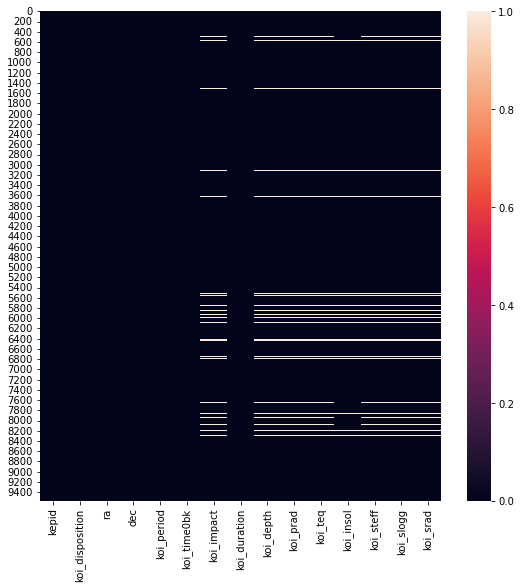

In [74]:
sns.heatmap(df.isna())

There appears to be a lot of missing values to deal with.

In [75]:
# Number of false positives within the entire dataset
df.koi_disposition.value_counts(normalize=True)

FALSE POSITIVE    0.525199
CONFIRMED         0.239753
CANDIDATE         0.235048
Name: koi_disposition, dtype: float64

In [76]:
# Number of false positives within the missing values for srad.
null_srad_values = df[df.isnull()['koi_srad']]
null_srad_values['koi_disposition'].value_counts(normalize=True)

FALSE POSITIVE    0.823691
CANDIDATE         0.173554
CONFIRMED         0.002755
Name: koi_disposition, dtype: float64

There are 14% more false positives among the NA values.

In [79]:
df.dropna(axis=0, inplace=True) # solution is to just drop them.

In [81]:
df.koi_disposition.value_counts(normalize=True)

FALSE POSITIVE    0.513422
CONFIRMED         0.249103
CANDIDATE         0.237474
Name: koi_disposition, dtype: float64

Thankfully without the NA values the distribution of test points is very similar

High correlation values on (koi_Slogg,koi_Srad), (koi_prad, koi_impact).

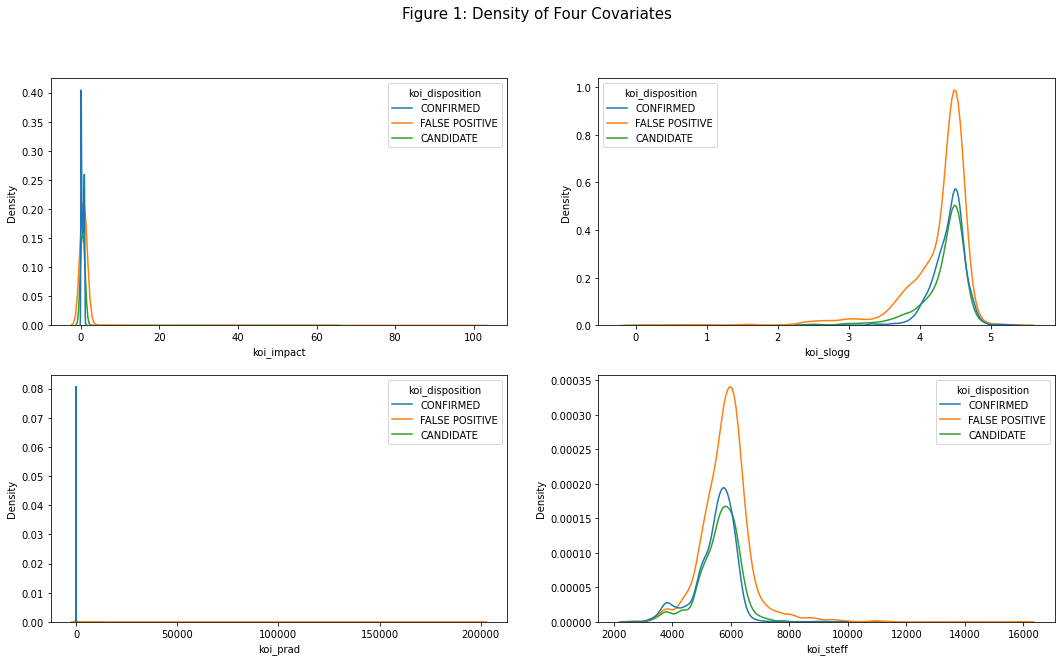

In [116]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

sns.kdeplot(df['koi_impact'], hue=df['koi_disposition'], ax=axes[0, 0])
# axes[0, 0].set_title(f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')

sns.kdeplot(df['koi_slogg'], hue=df['koi_disposition'], ax=axes[0, 1])
sns.kdeplot(df['koi_prad'], hue=df['koi_disposition'], ax=axes[1, 0])
sns.kdeplot(df['koi_steff'], hue=df['koi_disposition'], ax=axes[1, 1])
plt.suptitle('Figure 1: Density of Four Covariates', fontsize=15)
plt.savefig('figures/figure1_density_4_covariates.png', dpi=400)


To further investigate any deviations between variables in the training and test set we can use the KS test. It's a ...explain more here and write down mathematical form.

In [134]:
from pprint import PrettyPrinter
from scipy.stats import kstest 
pp = PrettyPrinter(indent=2)

df_test = df[df.koi_disposition == 'CANDIDATE']
df_train = df[df.koi_disposition != 'CANDIDATE']
ks_tests = {}
for col in df.columns:
    dist_test = kstest(df_test[col], df_train[col])[1]
    ks_tests[col] = np.around(dist_test,4)
pp.pprint(ks_tests)

{ 'dec': 0.0356,
  'kepid': 0.0358,
  'koi_depth': 0.0,
  'koi_depth_err1': 0.0,
  'koi_depth_err2': 0.0,
  'koi_disposition': 0.0,
  'koi_duration': 0.0,
  'koi_duration_err1': 0.0,
  'koi_duration_err2': 0.0,
  'koi_fpflag_co': 0.0,
  'koi_fpflag_ec': 0.0,
  'koi_fpflag_nt': 0.0,
  'koi_fpflag_ss': 0.0,
  'koi_impact': 0.0,
  'koi_impact_err1': 0.0,
  'koi_impact_err2': 0.0,
  'koi_insol': 0.0,
  'koi_insol_err1': 0.0,
  'koi_insol_err2': 0.0,
  'koi_period': 0.0,
  'koi_period_err1': 0.0,
  'koi_period_err2': 0.0,
  'koi_prad': 0.0,
  'koi_prad_err1': 0.0,
  'koi_prad_err2': 0.0,
  'koi_slogg': 0.2185,
  'koi_slogg_err1': 0.0006,
  'koi_slogg_err2': 0.0105,
  'koi_srad': 0.0023,
  'koi_srad_err1': 0.0062,
  'koi_srad_err2': 0.0503,
  'koi_steff': 0.0,
  'koi_steff_err1': 0.0,
  'koi_steff_err2': 0.0006,
  'koi_teq': 0.0,
  'koi_teq_err1': 1.0,
  'koi_teq_err2': 1.0,
  'koi_time0bk': 0.0,
  'koi_time0bk_err1': 0.0,
  'koi_time0bk_err2': 0.0,
  'ra': 0.0033}


### INFERENCE Full Conformal

['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec']

In [142]:
from sklearn.decomposition import PCA
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('KOI.csv')

error_columns = list(df.columns[df.columns.str.contains('err')]) # This is when removing the error columns
flag_columns = list(df.columns[df.columns.str.contains('flag')]) # We need to remove flag variables
df.drop(['ra', 'dec', 'koi_insol', 'kepid'] + flag_columns + error_columns, axis=1, inplace=True)
df.dropna(inplace=True) # solution is to just drop them.

df_test = df[df.koi_disposition == 'CANDIDATE'].reset_index(drop=True)
df_train = df[df.koi_disposition != 'CANDIDATE'].reset_index(drop=True)
df.reset_index(drop=True,inplace=True)

# I SHOULD JUST MAKE THE ORIGINAL DF INTO PERECENTILES BEFORE CREATING TRAIN AND TEST SETS?
X_train = df_train.drop('koi_disposition',axis=1).rank(pct=True)
X_test = df_test.drop('koi_disposition',axis=1).rank(pct=True)
all_X = df.drop('koi_disposition',axis=1).rank(pct=True)

X_train = df_train.drop('koi_disposition',axis=1)
X_test = df_test.drop('koi_disposition',axis=1)
all_X = df.drop('koi_disposition',axis=1)
all_X.reset_index(inplace=True, drop=True) 
df = pd.concat((df.koi_disposition, all_X),axis=1) # Put koi_disposition back after not giving it a rank.


In [143]:
# Creating PCA and K means using only the ranked X data. 
pca = PCA(n_components=5)
pca_transformed = pca.fit_transform(all_X)

kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=500, n_init=30, random_state=42)
df['cluster'] = kmeans.fit_predict(pca_transformed)
# regular_df['cluster'] = kmeans.fit_predict(pca_transformed)

In [144]:
# regular_df_train = regular_df[regular_df['koi_disposition'] != 'CANDIDATE' ]
# regular_df_test = regular_df[regular_df['koi_disposition'] == 'CANDIDATE' ]

df_test = df[df.koi_disposition == 'CANDIDATE']
df_train = df[df.koi_disposition != 'CANDIDATE']

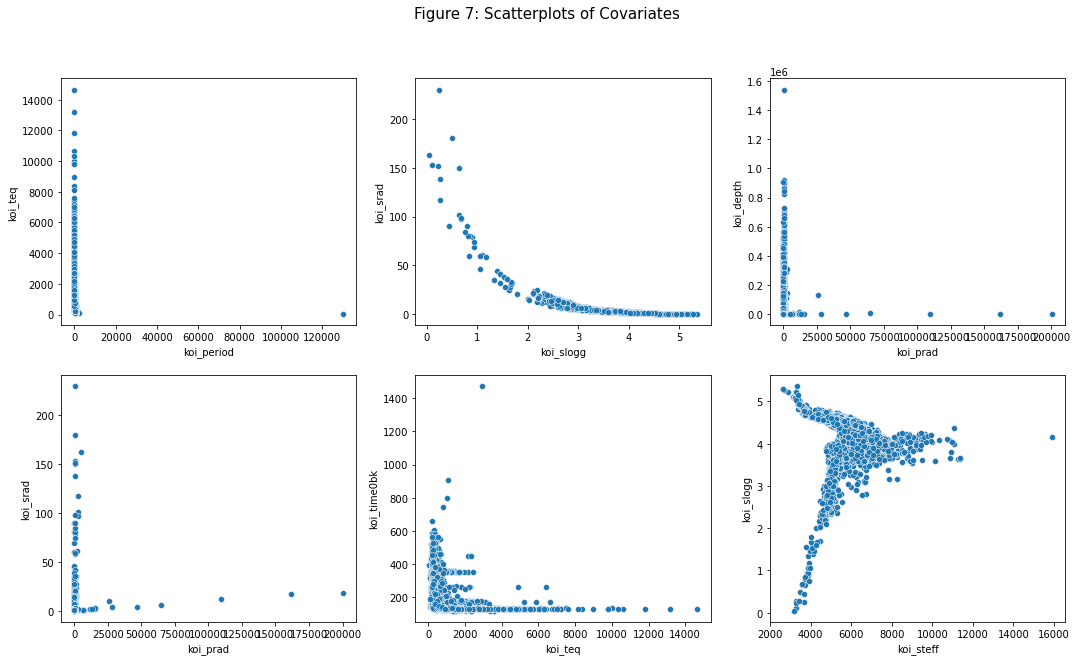

In [145]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

sns.scatterplot(ax=axes[0, 0], data=df, x = 'koi_period', y = 'koi_teq')
sns.scatterplot(ax=axes[0, 1], data=df, x = 'koi_slogg', y = 'koi_srad')
sns.scatterplot(ax=axes[0, 2], data=df, x = 'koi_prad', y = 'koi_depth')
sns.scatterplot(ax=axes[1, 0], data=df, x = 'koi_prad', y = 'koi_srad')
sns.scatterplot(ax=axes[1, 1], data=df, x = 'koi_teq', y = 'koi_time0bk')
sns.scatterplot(ax=axes[1, 2], data=df, x = 'koi_steff', y = 'koi_slogg')
plt.suptitle('Figure 7: Scatterplots of Covariates', fontsize=15)

plt.savefig('fig7.png')


In [733]:
X_test = df_test.drop(['koi_disposition', 'cluster'],axis=1).rank(pct=True)
X_test.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

test_df = pd.concat((X_test, df_test[['koi_disposition', 'cluster']]),axis=1)

# Calculates information needed for clustering
num_train_clusters = df[df.koi_disposition != 'CANDIDATE']['cluster'].value_counts()
num_test_clusters = df[df.koi_disposition == 'CANDIDATE']['cluster'].value_counts()

train_cluster_len = [num_train_clusters[i] for i in range(len(num_train_clusters))] # The indexes are in order of cluster.
test_cluster_len = [num_test_clusters[i] for i in range(len(num_test_clusters))] # The indexes are in order of cluster.

total_train_clus = np.sum(train_cluster_len)
total_test_clus = np.sum(test_cluster_len)

In [150]:
conda install -c ets factor_analyzer

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 4.14.0

Please update conda by running

    $ conda update -n base conda


Solving environment: / ^C
failed with initial frozen solve. Retrying with flexible solve.


Process SpawnPoolWorker-12:
Process SpawnPoolWorker-16:
Process SpawnPoolWorker-11:
Process SpawnPoolWorker-23:
Process SpawnPoolWorker-9:
Process SpawnPoolWorker-10:
Process SpawnPoolWorker-14:
Process SpawnPoolWorker-20:
Process SpawnPoolWorker-21:
Process SpawnPoolWorker-15:
Process SpawnPoolWorker-22:
Process SpawnPoolWorker-18:
Process SpawnPoolWorker-24:
Process SpawnPoolWorker-13:
Process SpawnPoolWorker-19:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mpi/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mpi/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mpi/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mpi/lib/python3.10/multiprocessing/queues.py", line 365, in ge


Note: you may need to restart the kernel to use updated packages.


Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mpi/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mpi/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mpi/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mpi/lib/python3.10/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/opt/homebrew/Caskroom/miniforge/base/envs/mpi/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


In [146]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(df.drop(['koi_disposition', 'cluster'],axis=1))
print(f'chi_square_value: {chi_square_value}')
print(f'p_value: {p_value}')

ModuleNotFoundError: No module named 'factor_analyzer'

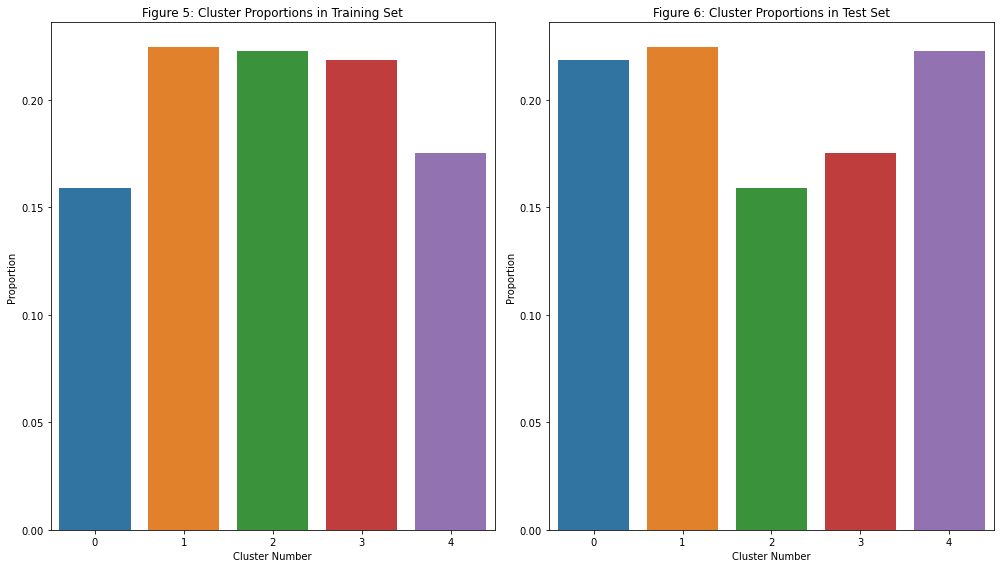

In [735]:
plt_train_clusters = df[df.koi_disposition != 'CANDIDATE']['cluster'].value_counts(normalize=True)
plt_test_clusters = df[df.koi_disposition == 'CANDIDATE']['cluster'].value_counts(normalize=True)

fig, axs = plt.subplots(ncols=2, figsize=(14,8))
fig = sns.barplot(x = plt_train_clusters.index, y = plt_train_clusters, ax=axs[0])
fig.set_title('Figure 5: Cluster Proportions in Training Set')
fig.set_ylabel('Proportion')
fig.set_xlabel('Cluster Number')

fig = sns.barplot(x = plt_test_clusters.index, y = plt_train_clusters, ax=axs[1])
fig.set_title('Figure 6: Cluster Proportions in Test Set')
fig.set_ylabel('Proportion')
fig.set_xlabel('Cluster Number')
plt.tight_layout()
plt.savefig('figure 5 & 6')

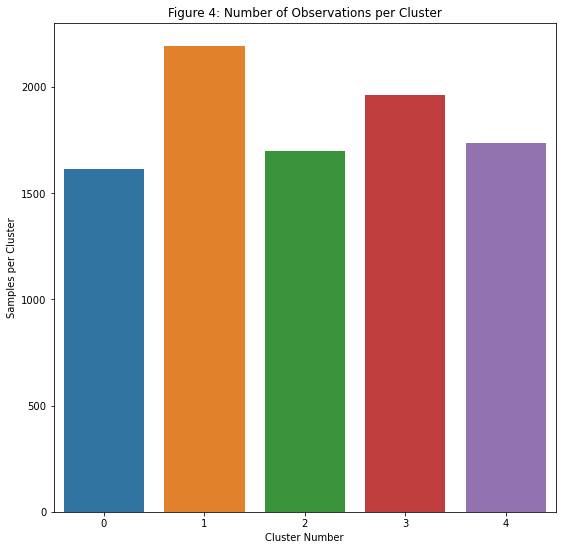

In [742]:
sns.barplot(x=df.cluster.value_counts(sort=False).index, y=df.cluster.value_counts(sort=False))
plt.ylabel('Samples per Cluster')
plt.title('Figure 4: Number of Observations per Cluster')
plt.xlabel('Cluster Number')
plt.savefig('fig4')

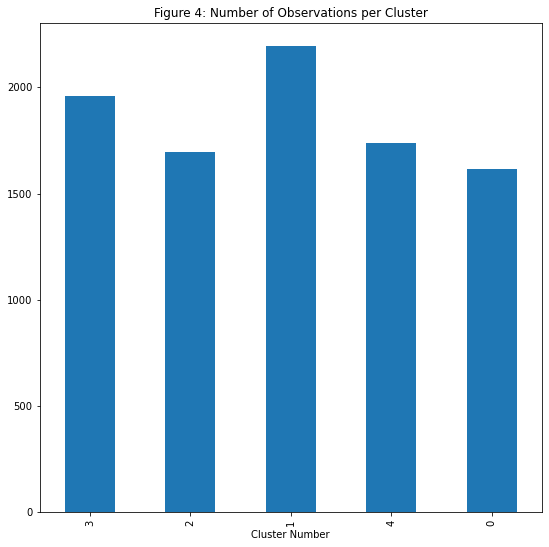

In [686]:
df.cluster.value_counts(sort=False).plot.bar()


In [724]:
def full_conformal(test_row, cp_df_train, alpha):
    """ Our main algorithm.
    """
    cp_conformal_df = cp_df_train.append(test_row) # appends the test row to the bottom  of training data
    X = cp_conformal_df.drop(['koi_disposition', 'cluster'], axis=1)
    y = cp_conformal_df['koi_disposition']

    # Calculates the denominator.
    test_clust = test_row.cluster
    denominator = 7015.999999999839
    q_test =  test_cluster_len[test_clust] / total_test_clus
    q_train = train_cluster_len[test_clust] / total_train_clus
    denominator += (q_test/q_train)
    
    # Calculates the weights for each cluster.
    weights = []
    for c_num in cp_conformal_df.cluster:
        q_test =  test_cluster_len[c_num] / total_test_clus
        q_train = train_cluster_len[c_num] / total_train_clus
        weight_i = (q_test / q_train) / (denominator)
        weights.append(weight_i)

    y.iloc[-1] = 'CONFIRMED'        # Put in the guessed value for y. 
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model_confirmed = LogisticRegression(max_iter=1000, C=100)
    model_confirmed.fit(X, y)

    y.iloc[-1] = 'FALSE POSITIVE'   # Put in the guessed value for y. 
    model_false_positive = LogisticRegression(max_iter=1000, C=100)
    model_false_positive.fit(X, y)

    scores_confirmed = 1/(model_confirmed.predict_proba(X)[:,0] + 0.00001)
    scores_fp = 1/(model_false_positive.predict_proba(X)[:,1] + 0.00001)

    # Keeps track of score on test sample.
    TEST_SCORE_confirmed = scores_confirmed[-1]
    TEST_SCORE_FP = scores_fp[-1]

    confirmed_df = pd.DataFrame({'Scores of Confirmed':scores_confirmed, 'Weights':weights})
    false_positive_df =  pd.DataFrame({'false positive score':scores_fp, 'Weights':weights})

    confirmed_df.sort_values(by='Scores of Confirmed',inplace=True)
    false_positive_df.sort_values(by='false positive score',inplace=True)

    confirmed_df['weight_cdf'] = np.cumsum(confirmed_df['Weights'])
    false_positive_df['weight_cdf'] = np.cumsum(false_positive_df['Weights'])

    # Checking if the score is within the 1-alpha weight quantile.
    prediction_set = []
    score_Q_confirmed = confirmed_df[confirmed_df['weight_cdf'] <= (1-alpha)]['Scores of Confirmed'].iloc[-1]
    score_Q_false_positive = false_positive_df[false_positive_df['weight_cdf'] <= (1-alpha)]['false positive score'].iloc[-1]

    if TEST_SCORE_confirmed < score_Q_confirmed:
        prediction_set.append('CONFIRMED')

    if TEST_SCORE_FP < score_Q_false_positive:
        prediction_set.append('FALSE POSITIVE')
    
    return prediction_set, confirmed_df

In [725]:
regular_df_test.reset_index(drop=True,inplace=True)
regular_df_train.reset_index(drop=True,inplace=True)

In [701]:
denominator = 0 
for c_num in regular_df_train.cluster:
    q_test =  test_cluster_len[c_num] / total_test_clus
    q_train = train_cluster_len[c_num] / total_train_clus
    denominator += (q_test/q_train)
denominator

7015.999999999839

In [702]:
predictions = []
cp_df_train = regular_df_train.copy() #9:31

for row in tqdm(range(len(regular_df_test))):
    prediction_set, confirmed_df = full_conformal(test_row=regular_df_test.iloc[row], cp_df_train=cp_df_train, alpha=0.1)
    predictions.append(prediction_set) 

  5%|▌         | 114/2185 [00:29<08:50,  3.90it/s]


KeyboardInterrupt: 

In [ ]:
both = 0
false_pos_single = 0
confirmed_single = 0
crazy_case_nothing_in_set = 0
for lst in predictions:
    if len(lst) == 2:
        both += 1
    elif len(lst) == 1:
        if lst == 'CONFIRMED':
            confirmed_single += 1
        else:
            false_pos_single += 1
    else:
        crazy_case_nothing_in_set += 1

print(f'both: {both/len(predictions)}')
print(f'false_pos_single: {false_pos_single/len(predictions)}')
print(f'confirmed_single: {confirmed_single/len(predictions)}')
print(f'crazy_case_nothing_in_set: {crazy_case_nothing_in_set/len(predictions)}')

both: 0.8320366132723113
false_pos_single: 0.1679633867276888
confirmed_single: 0.0
crazy_case_nothing_in_set: 0.0


In [726]:
# c = 0
# for i in predictions:
#     c+= len(i)
# c

### Simulating Data

In [514]:
from numpy import dot
from numpy.linalg import norm

pca_training = pca_transformed[np.where(df.koi_disposition != 'CANDIDATE')]
pca_test = pca_transformed[np.where(df.koi_disposition == 'CANDIDATE')]

pca_transformed # Find the indexs for training and test

array([[-0.18623403,  0.23894612, -0.05993808,  0.3203594 ,  0.04502604],
       [-0.55184595,  0.06672517,  0.06360989,  0.03468027,  0.10053628],
       [-0.37012132,  0.09385694,  0.4909558 , -0.07811269,  0.28434044],
       ...,
       [ 0.67590271,  0.22598731, -0.56058212, -0.01232081, -0.2342279 ],
       [ 0.93073278,  0.26110155, -0.31497958,  0.07606314, -0.08133098],
       [ 0.477381  , -0.04713742, -0.5955417 , -0.05010942, -0.1094488 ]])

In [528]:
Z_list = []
p_bar = np.mean(pca_test,axis=0) - np.mean(pca_training,axis=0)

for i in range(len(pca_transformed)):
    p_i = pca_transformed[i]
    probability_i = ((dot(p_i, p_bar)/(norm(p_i)*norm(p_bar))) + 1) / 8
    Z_list.append(probability_i)
Z_list = np.random.binomial(n=1, p=Z_list)

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [530]:
all_xs = regular_df.drop(['koi_disposition','cluster'],axis=1)

In [531]:
scaler = StandardScaler()
all_xs = scaler.fit_transform(all_xs)

In [532]:
simulated_y = {} # Using dictionary to keep track of index for concattinating with main dataframe.
for num, Z in enumerate(Z_list):
    if Z == 0:
        y_i = np.random.binomial(n=1,p=sigmoid(np.sum(all_xs[num])))
        simulated_y[num] = y_i
    else:
        y_i = np.random.binomial(n=1,p=0.5) 
        simulated_y[num] = y_i

In [533]:
regular_df.reset_index(drop=True,inplace=True)
sim_df = pd.concat((pd.Series(simulated_y, name='simulated_y'),regular_df),axis=1)

### Running Simulations

In [534]:
sim_df.simulated_y.value_counts()

0    5064
1    4137
Name: simulated_y, dtype: int64

In [621]:
def full_conformal(test_row, cp_df_train, alpha):
    cp_conformal_df = cp_df_train.append(test_row) # appends the test row to the bottom  of training data
    X = cp_conformal_df.drop(['koi_disposition', 'cluster', 'simulated_y'], axis=1)
    y = cp_conformal_df['simulated_y']

    # Calculates the denominator.
    test_clust = test_row.cluster
    denominator = 7015.999999999839
    q_test =  test_cluster_len[test_clust] / total_test_clus
    q_train = train_cluster_len[test_clust] / total_train_clus
    denominator += (q_test/q_train)
    
    # Calculates the weights for each cluster.
    weights = []
    for c_num in cp_conformal_df.cluster:
        q_test =  test_cluster_len[c_num] / total_test_clus
        q_train = train_cluster_len[c_num] / total_train_clus
        weight_i = (q_test / q_train) / (denominator)
        weights.append(weight_i)
    
    # weights = np.ones(len(cp_conformal_df.cluster)) * 1/len(cp_conformal_df.cluster)

    y.iloc[-1] = 0     # Put in the guessed value for y. 
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    model_confirmed = LogisticRegression(max_iter=1000, C=100)
    model_confirmed.fit(X, y)

    y.iloc[-1] = 1   # Put in the guessed value for y. 
    model_false_positive = LogisticRegression(max_iter=1000, C=100)
    model_false_positive.fit(X, y)

    scores_confirmed = 1/(model_confirmed.predict_proba(X)[:,0] + 0.00001)
    scores_fp = 1/(model_false_positive.predict_proba(X)[:,1] + 0.00001)

    # Keeps track of score on test sample.
    TEST_SCORE_confirmed = scores_confirmed[-1]
    TEST_SCORE_FP = scores_fp[-1]

    confirmed_df = pd.DataFrame({'Scores of Confirmed':scores_confirmed, 'Weights':weights})
    false_positive_df =  pd.DataFrame({'false positive score':scores_fp, 'Weights':weights})

    confirmed_df.sort_values(by='Scores of Confirmed',inplace=True)
    false_positive_df.sort_values(by='false positive score',inplace=True)

    confirmed_df['weight_cdf'] = np.cumsum(confirmed_df['Weights'])
    false_positive_df['weight_cdf'] = np.cumsum(false_positive_df['Weights'])

    # Checking if the score is within the 1-alpha weight quantile.
    prediction_set = []
    score_Q_confirmed = confirmed_df[confirmed_df['weight_cdf'] <= (1-alpha)]['Scores of Confirmed'].iloc[-1]
    score_Q_false_positive = false_positive_df[false_positive_df['weight_cdf'] <= (1-alpha)]['false positive score'].iloc[-1]

    if TEST_SCORE_confirmed < score_Q_confirmed:
        prediction_set.append('CONFIRMED')

    if TEST_SCORE_FP < score_Q_false_positive:
        prediction_set.append('FALSE POSITIVE')
    
    return prediction_set, confirmed_df

In [617]:
all_X # should be percentile.

,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_steff,koi_slogg,koi_srad
0,0.504402,0.752853,0.207640,0.348169,0.596674,0.475166,0.441908,0.311216,0.564178,0.397185
1,0.794588,0.717857,0.532714,0.593414,0.673405,0.569449,0.179491,0.311216,0.564178,0.397185
2,0.656450,0.808608,0.829258,0.124878,0.849364,0.748071,0.325345,0.571297,0.752310,0.311923
3,0.179220,0.748723,0.971416,0.241822,0.838604,0.834420,0.754266,0.537659,0.804749,0.191229
4,0.240409,0.769373,0.614988,0.102380,0.591784,0.559722,0.758124,0.685849,0.498044,0.566732
...,...,...,...,...,...,...,...,...,...,...
9196,0.485165,0.133138,0.664547,0.627323,0.130203,0.149658,0.532062,0.420172,0.307521,0.611510
9197,0.010651,0.052060,0.950929,0.397674,0.757092,0.817629,0.906532,0.420172,0.716661,0.365286
9198,0.179437,0.275840,0.106130,0.377296,0.051625,0.041191,0.812575,0.754211,0.515161,0.550429
9199,0.046517,0.173351,0.208401,0.013694,0.155309,0.136507,0.923487,0.786328,0.521193,0.561298


In [622]:
pca = PCA(n_components=5)
pca_transformed = pca.fit_transform(all_X)

kmeans = KMeans(n_clusters=20, init='k-means++', max_iter=500, n_init=30, random_state=42)
df['cluster'] = kmeans.fit_predict(pca_transformed)
regular_df['cluster'] = kmeans.fit_predict(pca_transformed)

regular_df.reset_index(drop=True,inplace=True)
sim_df = pd.concat((pd.Series(simulated_y, name='simulated_y'),regular_df),axis=1)

simulated_df_test = sim_df[sim_df.koi_disposition == 'CANDIDATE']
cp_df_train = sim_df.copy() 

num_train_clusters = df[df.koi_disposition != 'CANDIDATE']['cluster'].value_counts()
num_test_clusters = df[df.koi_disposition == 'CANDIDATE']['cluster'].value_counts()

train_cluster_len = [num_train_clusters[i] for i in range(len(num_train_clusters))] # The indexes are in order of cluster.
test_cluster_len = [num_test_clusters[i] for i in range(len(num_test_clusters))] # The indexes are in order of cluster.

total_train_clus = np.sum(train_cluster_len)
total_test_clus = np.sum(test_cluster_len)

predictions = []
for row in tqdm(range(len(simulated_df_test))):
    prediction_set, confirmed_df = full_conformal(test_row=simulated_df_test.iloc[row], cp_df_train=cp_df_train, alpha=0.1)
    predictions.append(prediction_set) 

100%|██████████| 2185/2185 [02:09<00:00, 16.85it/s]


In [623]:
where_suck = []
coverage=0

def change_simulated_test_var_name(x):
        if x == 0:
            return 'CONFIRMED'
        else:
            return 'FALSE POSITIVE'

check = simulated_df_test['simulated_y'].apply(lambda x: change_simulated_test_var_name(x))
for i in range(len(predictions)):
    if check.iloc[i] in predictions[i]:
        coverage += 1
    else:
        where_suck.append(check.iloc[i])


In [624]:
final_clust = len([i for i in predictions if len(i)<=1])/len(predictions) # zero clusters
final_clust_cov = coverage/len(predictions) 

In [591]:
zero_clust = len([i for i in predictions if len(i)<=1])/len(predictions) # zero clusters
zero_clust_cov = coverage/len(predictions) 

In [581]:
plot_coverage = []
plot_power = []
total_predictions = []

for i in range(2,21):
    pca = PCA(n_components=5)
    pca_transformed = pca.fit_transform(all_X)

    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=30, random_state=42)
    df['cluster'] = kmeans.fit_predict(pca_transformed)
    regular_df['cluster'] = kmeans.fit_predict(pca_transformed)

    regular_df.reset_index(drop=True,inplace=True)
    sim_df = pd.concat((pd.Series(simulated_y, name='simulated_y'),regular_df),axis=1)

    simulated_df_test = sim_df[sim_df.koi_disposition == 'CANDIDATE']
    cp_df_train = sim_df.copy() 

    num_train_clusters = df[df.koi_disposition != 'CANDIDATE']['cluster'].value_counts()
    num_test_clusters = df[df.koi_disposition == 'CANDIDATE']['cluster'].value_counts()

    train_cluster_len = [num_train_clusters[i] for i in range(len(num_train_clusters))] # The indexes are in order of cluster.
    test_cluster_len = [num_test_clusters[i] for i in range(len(num_test_clusters))] # The indexes are in order of cluster.

    total_train_clus = np.sum(train_cluster_len)
    total_test_clus = np.sum(test_cluster_len)

    predictions = []
    for row in tqdm(range(len(simulated_df_test))):
        prediction_set, confirmed_df = full_conformal(test_row=simulated_df_test.iloc[row], cp_df_train=cp_df_train, alpha=0.1)
        predictions.append(prediction_set) 

    def kk(x):
        if x == 0:
            return 'CONFIRMED'
        else:
            return 'FALSE POSITIVE'
    check = simulated_df_test['simulated_y'].apply(lambda x: kk(x))

    coverage = 0
    where_suck = []
    for i in range(len(predictions)):
        if check.iloc[i] in predictions[i]:
            coverage += 1
        else:
            where_suck.append(check.iloc[i])
            
    total_predictions.append(predictions)
    plot_coverage.append(coverage/len(check))
    plot_power.append(len([i for i in predictions if len(i)<=1])/len(predictions))

100%|██████████| 2185/2185 [02:16<00:00, 15.96it/s]


In [625]:
plot_coverage.append(final_clust)
plot_power.append(final_clust_cov)

In [594]:
plot_coverage.insert(0, zero_clust_cov)

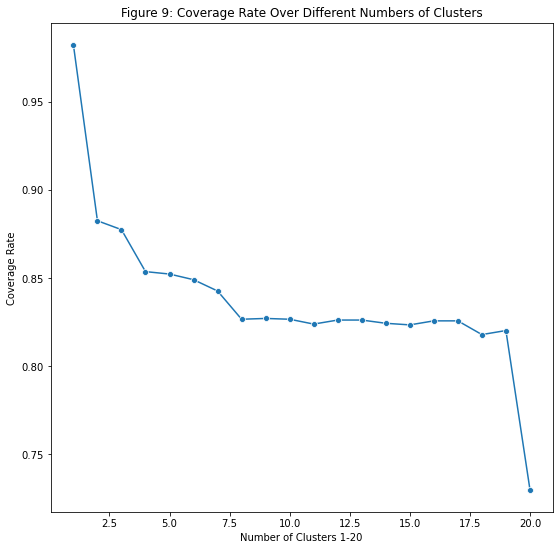

In [670]:
sns.lineplot(x=np.arange(1,21), y=plot_coverage, marker='o')
plt.title('Figure 9: Coverage Rate Over Different Numbers of Clusters')
plt.xlabel('Number of Clusters 1-20')
plt.ylabel('Coverage Rate')
plt.savefig('fig9')

In [605]:
plot_power.insert(0, zero_clust)

22

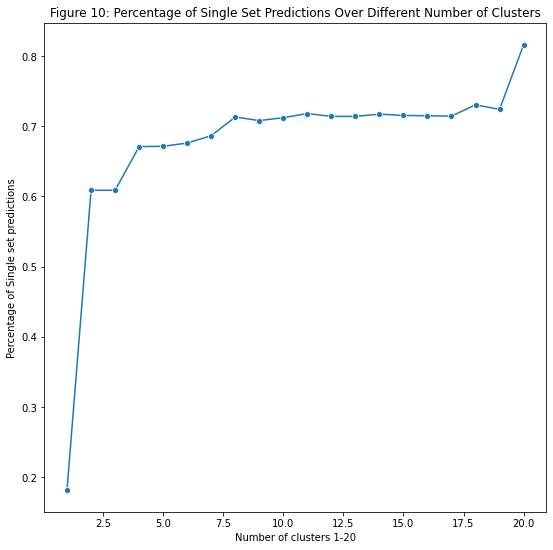

In [672]:
sns.lineplot(x=np.arange(1,21), y=plot_power, marker='o')
plt.title('Figure 10: Percentage of Single Set Predictions Over Different Number of Clusters')
plt.ylabel('Percentage of Single set predictions')
plt.xlabel('Number of clusters 1-20')
plt.savefig('fig10')

### Verifying K-Means and PCA

In [228]:
all = all_X.copy()

In [229]:
# Or fit on all the data.
pca = PCA(n_components=5)
all = pca.fit_transform(all)
pca.explained_variance_ratio_.sum() # 5 components can explain 91% variance. 

0.9106992325061034

In [230]:
pca_train = all[np.where(df.koi_disposition != 'CANDIDATE')]
pca_test = all[np.where(df.koi_disposition == 'CANDIDATE')]

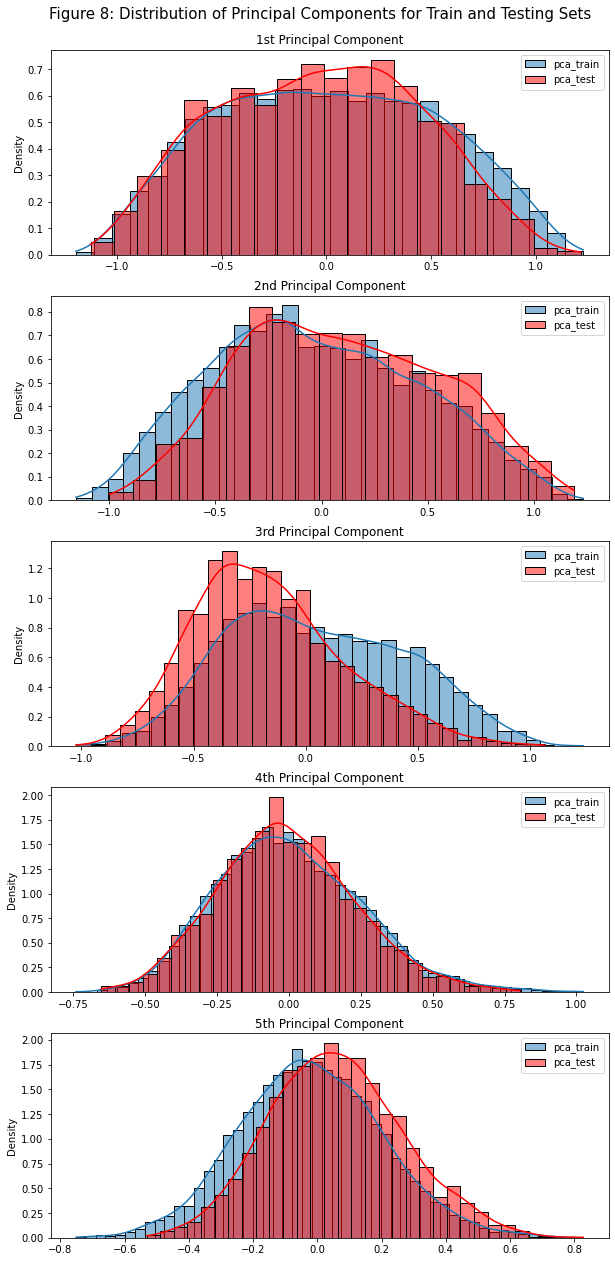

In [677]:
fig, axs = plt.subplots(nrows=5, figsize=(10,20))


sns.histplot(pca_train[:,0], label='pca_train', ax=axs[0], kde=True, stat='density')
sns.histplot(pca_test[:,0], color='r', label='pca_test', ax=axs[0], kde=True,stat='density')
axs[0].set_title('1st Principal Component')
sns.histplot(pca_train[:,1], label='pca_train', ax=axs[1], kde=True,stat='density')
sns.histplot(pca_test[:,1], color='r', label='pca_test', kde=True,ax=axs[1], stat='density')
axs[1].set_title('2nd Principal Component')
sns.histplot(pca_train[:,2], label='pca_train', ax=axs[2], kde=True,stat='density')
sns.histplot(pca_test[:,2], color='r', label='pca_test', kde=True,ax=axs[2], stat='density')
axs[2].set_title('3rd Principal Component')
sns.histplot(pca_train[:,3], label='pca_train', ax=axs[3], kde=True,stat='density')
sns.histplot(pca_test[:,3], color='r', label='pca_test', ax=axs[3], kde=True,stat='density')
axs[3].set_title('4th Principal Component')
sns.histplot(pca_train[:,4], label='pca_train', ax=axs[4], kde=True, stat='density')
sns.histplot(pca_test[:,4], color='r', label='pca_test', ax=axs[4], kde=True, stat='density')
axs[4].set_title('5th Principal Component')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

fig.subplots_adjust(top=0.95)
plt.suptitle('Figure 8: Distribution of Principal Components for Train and Testing Sets', fontsize=15)
plt.savefig('fig8')


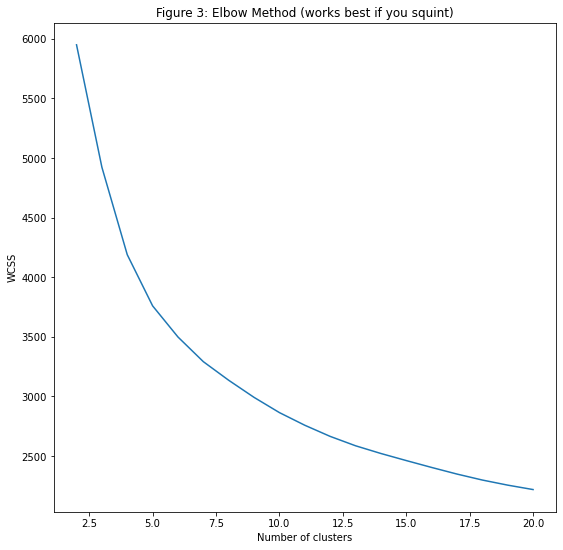

In [206]:
max_clusters = 20

wcss = []
for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=25, random_state=42)
    kmeans.fit(all_X)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, max_clusters + 1), wcss)
plt.title('Figure 3: Elbow Method (works best if you squint)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('figure 3')

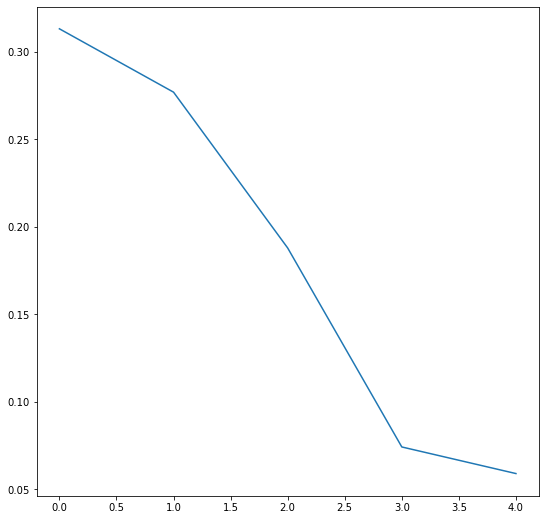

In [274]:
plt.plot(pca.explained_variance_ratio_)

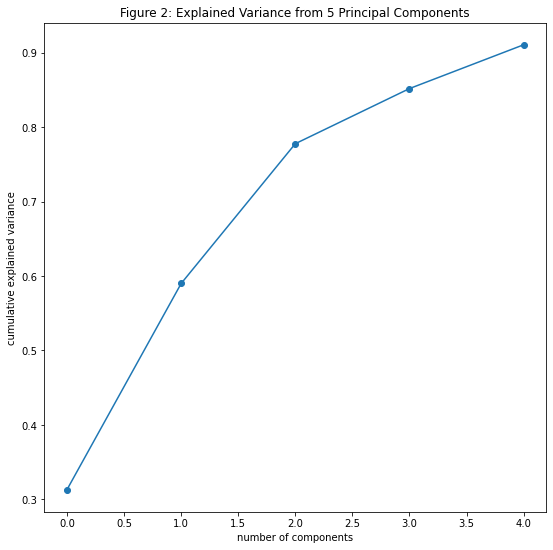

In [205]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Figure 2: Explained Variance from 5 Principal Components')
plt.savefig('fig2')

### Logit Regression

In [124]:
from sklearn.linear_model import LogisticRegression
from statsmodels.tools.tools import add_constant
from statsmodels.discrete.discrete_model import Logit

In [125]:
X = regular_df_train.drop(['koi_disposition', 'cluster'], axis=1)
y = pd.get_dummies(regular_df_train['koi_disposition'],drop_first=True).to_numpy()
X = add_constant(X)
model = Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: 66.242443
         Iterations 15


/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [126]:
results_summary = model.summary()
print(results_summary)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7016
Model:                          Logit   Df Residuals:                     7005
Method:                           MLE   Df Model:                           10
Date:                Wed, 16 Mar 2022   Pseudo R-squ.:                     inf
Time:                        10:56:28   Log-Likelihood:            -4.6476e+05
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -26.7236      2.145    -12.459      0.000     -30.927     -22.520
koi_period       0.0167      0.001     19.836      0.000       0.015       0.018
koi_time0bk     -0.0028      0.001     -3.02

/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


# Permutation test for distribution check

#### Permutation tests

In [313]:
from scipy.stats import ttest_ind
from scipy.stats import median_test

In [314]:
t_test_p_vals = {}
for col in df_train.columns[1:]:
    p_val = ttest_ind(df_test[col], df_train[col],permutations=20000, equal_var=False)[1]
    t_test_p_vals[col] = p_val

In [315]:
pp.pprint(t_test_p_vals) # Equal variance = False

{   'dec': 0.35305,
    'koi_depth': 0.0,
    'koi_duration': 0.0,
    'koi_impact': 0.0,
    'koi_insol': 0.0,
    'koi_period': 0.0063,
    'koi_prad': 0.0,
    'koi_slogg': 0.5487,
    'koi_srad': 0.3019,
    'koi_steff': 0.00185,
    'koi_teq': 0.0,
    'koi_time0bk': 0.20385,
    'ra': 0.0105}


In [162]:
pp.pprint(t_test_p_vals) # Equal variance assumption = True

{   'dec': 0.0778,
    'koi_depth': 0.0,
    'koi_duration': 0.0,
    'koi_impact': 0.00265,
    'koi_insol': 0.47005,
    'koi_period': 0.0,
    'koi_prad': 0.0897,
    'koi_slogg': 0.00855,
    'koi_srad': 0.15415,
    'koi_steff': 0.0,
    'koi_teq': 0.0,
    'koi_time0bk': 0.0002,
    'ra': 0.00215}


In [180]:
def permut_p_value(column_name, num_perm=15000, variance=False):
    """ 
    """
    permutation_statistics = []
    if variance:
        original_statistic = np.var(df_test[column_name])
        for i in range(num_perm):
            permutation = np.random.permutation(df[column_name])[:2185]
            variance_of_permutation = np.var(permutation)
            permutation_statistics.append(variance_of_permutation)
    else:
        stat, p, med, tbl = median_test(df_test[column_name], df_train[column_name])
        original_statistic = np.abs(stat)
        for i in range(num_perm):
            permutation_set = np.random.permutation(df[column_name])
            test_set = permutation_set[:2185]
            train_set = permutation_set[2185:]
            stat,perm_stat,_,_ = median_test(test_set, train_set)
            permutation_statistics.append(stat)
    permutation_statistics = np.array(permutation_statistics)

    p_val = 1 + sum(np.abs(permutation_statistics) >= original_statistic)/(num_perm - 1) # Is there a one minus in denominator?
    return p_val


In [391]:
def permut_p_value(column_name, num_perm=15000):
    """ 
    Permute using the KS test statistic.
    """
    permutation_statistics = []
    original_statistic = kstest(df_test[column_name], df_train[column_name])[1]
    for i in range(num_perm):
        shuffled_df = np.random.permutation(df[column_name])
        test_permutation = shuffled_df[:2185]
        train_permutation = shuffled_df[2185:]
        ks_statistic = kstest(test_permutation, train_permutation)[1]
        permutation_statistics.append(ks_statistic)
    permutation_statistics = np.array(permutation_statistics)

    p_val = (1 + sum(permutation_statistics <= original_statistic))/(num_perm)
    return np.around(p_val,4)


In [392]:
p_values_permut = {}
for col in tqdm(df.columns[1:]):
    p_val = permut_p_value(col)
    p_values_permut[col] = p_val

100%|██████████| 17/17 [1:04:52<00:00, 228.99s/it]


In [395]:
pd.Series(p_values_permut).to_csv('p_values.csv')

In [396]:
pd.read_csv('p_values.csv')

,Unnamed: 0,0
0,ra,0.0022
1,dec,0.0725
2,koi_fpflag_nt,0.0001
3,koi_fpflag_ss,0.0001
4,koi_fpflag_co,0.0001
5,koi_fpflag_ec,0.0001
6,koi_period,0.0001
7,koi_time0bk,0.0001
8,koi_impact,0.0001
9,koi_duration,0.0001
